In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

random_state = 0
np.random.seed(random_state)
pd.set_option("display.max_columns", False)

In [2]:
!wget -r -N -c -np https://physionet.org/files/eicu-crd-demo/2.0.1/ &> /dev/null

In [3]:
!ls physionet.org/files/eicu-crd-demo/2.0.1/

admissiondrug.csv.gz		  LICENSE.txt
admissionDx.csv.gz		  medication.csv.gz
allergy.csv.gz			  microLab.csv.gz
apacheApsVar.csv.gz		  note.csv.gz
apachePatientResult.csv.gz	  nurseAssessment.csv.gz
apachePredVar.csv.gz		  nurseCare.csv.gz
carePlanCareProvider.csv.gz	  nurseCharting.csv.gz
carePlanEOL.csv.gz		  pastHistory.csv.gz
carePlanGeneral.csv.gz		  patient.csv.gz
carePlanGoal.csv.gz		  physicalExam.csv.gz
carePlanInfectiousDisease.csv.gz  respiratoryCare.csv.gz
customLab.csv.gz		  respiratoryCharting.csv.gz
diagnosis.csv.gz		  SHA256SUMS.txt
hospital.csv.gz			  sqlite
index.html			  treatment.csv.gz
infusiondrug.csv.gz		  vitalAperiodic.csv.gz
intakeOutput.csv.gz		  vitalPeriodic.csv.gz
lab.csv.gz


In [4]:
patients = pd.read_csv("physionet.org/files/eicu-crd-demo/2.0.1/patient.csv.gz")

In [5]:
patients.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141764,129391,Female,87,Caucasian,59,91,NaN,157.5,23:36:00,-2258,NaN,2015,19:20:00,366,Home,Alive,Med-Surg ICU,13:14:00,ICU to SDU,2,stepdown/other,NaN,NaN,18:58:00,344,Home,Alive,002-1039
1,141765,129391,Female,87,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",157.5,23:36:00,-8,NaN,2015,19:20:00,2616,Home,Alive,Med-Surg ICU,23:44:00,Emergency Department,1,admit,46.5,45.0,13:14:00,2250,Step-Down Unit (SDU),Alive,002-1039
2,143870,131022,Male,76,Caucasian,68,103,"Endarterectomy, carotid",167.0,20:46:00,-1,Operating Room,2014,17:05:00,1218,Home,Alive,SICU,20:47:00,Operating Room,1,admit,77.5,79.4,10:00:00,793,Floor,Alive,002-12289
3,144815,131736,Female,34,Caucasian,56,82,"Overdose, other toxin, poison or drug",172.7,01:44:00,-23,Emergency Department,2015,21:05:00,1138,Other Hospital,Alive,Med-Surg ICU,02:07:00,Emergency Department,1,admit,60.3,60.7,20:48:00,1121,Other External,Alive,002-1116
4,145427,132209,Male,61,Caucasian,68,103,"GI perforation/rupture, surgery for",177.8,23:48:00,-10,Emergency Department,2014,15:41:00,5263,Home,Alive,SICU,23:58:00,Operating Room,1,admit,91.7,93.1,22:47:00,1369,Floor,Alive,002-12243


In [6]:
patients = patients[[
    "patientunitstayid", "patienthealthsystemstayid", "gender", "age", 
    "ethnicity", "apacheadmissiondx", "admissionheight", "hospitaladmitsource", 
    "hospitaldischargestatus", "unitadmitsource", "unitvisitnumber", 
    "admissionweight"
]]

# Note that the age column has a value "> 89" to mitigate re-identification risks. This entry prevents the conversion to a number. We'll map this to 90.

In [7]:
patients["age"].unique()

array(['87', '76', '34', '61', '55', '60', '28', '> 89', '59', '44', '66',
       '41', '63', '57', '52', '23', '73', '39', '20', '29', '71', '18',
       '83', '84', '47', '38', '46', '49', '81', '68', '51', '17', '89',
       '85', '56', '80', '48', '74', '16', '64', '75', '67', '72', '82',
       '77', '78', '58', '88', '53', '54', '65', '69', '62', '50', '42',
       '32', '25', '40', '43', '79', '70', '86', '30', '37', '26', '19',
       '31', '21', '45', nan, '22', '27', '33', '35', '24', '36', '15'],
      dtype=object)

In [8]:
patients.loc[patients["age"] == "> 89", "age"] = "90"
patients["age"] = pd.to_numeric(patients["age"])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-8-23eb4a28772c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients["age"] = pd.to_numeric(patients["age"])


Text(0.5, 0, 'Hospital discharge status')

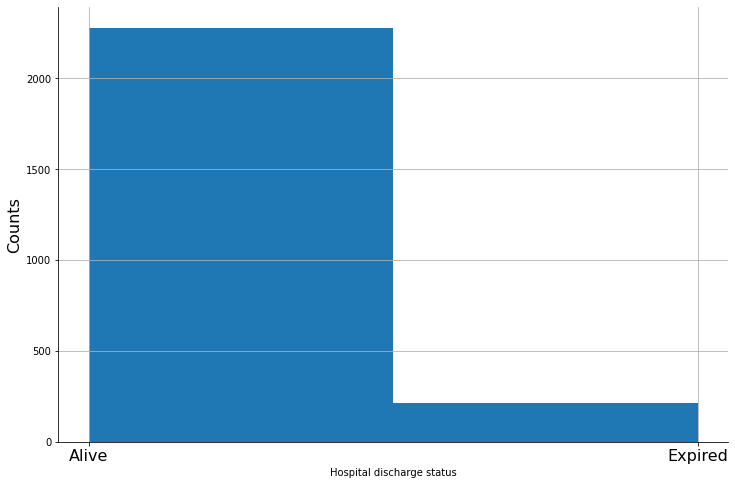

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
patients["hospitaldischargestatus"].hist(bins=2, xlabelsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Counts", fontsize=16)
ax.set_xlabel("Hospital discharge status")

# It is very common when looking at clinical outcomes, such as mortality, that the outcome is very unevenly distributed. This makes prediction problems really challenging!

In [10]:
no_alive = len(patients[patients['hospitaldischargestatus'] == 'Alive'])
no_died = len(patients[patients["hospitaldischargestatus"] == "Expired"])
no_total = no_alive + no_died

In [11]:
print(f"{no_alive} patients who left the hospital alive ({100*no_alive/no_total:.2f}%) and {no_died} who died in hospital ({100*no_died/no_total:.2f}%).")

2280 patients who left the hospital alive (91.49%) and 212 who died in hospital (8.51%).


# Let's see if we can predict who will leave the hospital alive! We'll only use the first unit stay during a hospitalization.

Task 1: Keep only the first stay for each patient

In [12]:
patients = patients.loc[patients.groupby("patienthealthsystemstayid")["unitvisitnumber"].idxmin().reset_index(drop=True), :]

In [13]:
len(patients)

2174

# Since we only keep the first stay for each patient, the unitvisitnumber is not required anymore

In [14]:
patients = patients.drop(["patientunitstayid", "unitvisitnumber"], axis=1)

# Convert some features to categorical and look at the histograms

In [15]:
categorical_features = ["gender", "ethnicity", "apacheadmissiondx", "hospitaladmitsource", "hospitaldischargestatus", "unitadmitsource"]
for feat in categorical_features:
    patients.loc[:, feat] = patients.loc[:, feat].astype("category")

<ipython-input-16-f6d488d7b438>:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


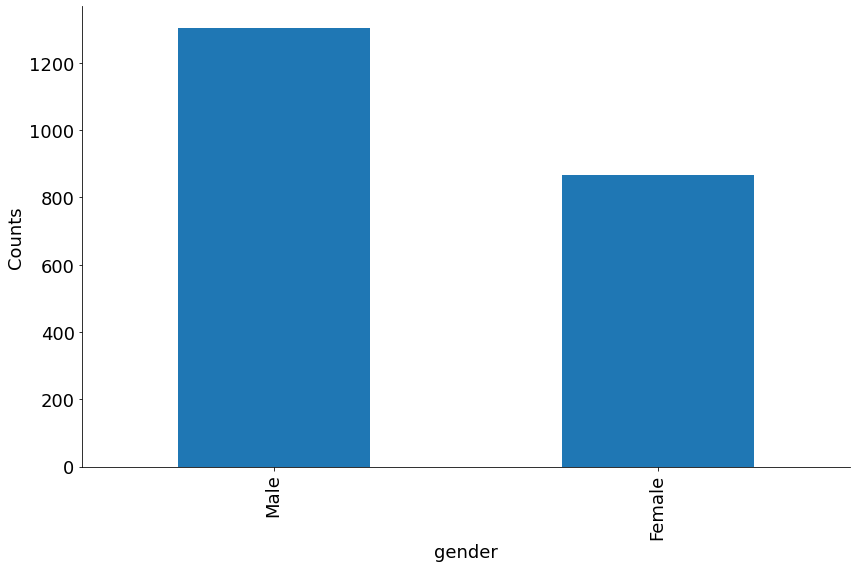

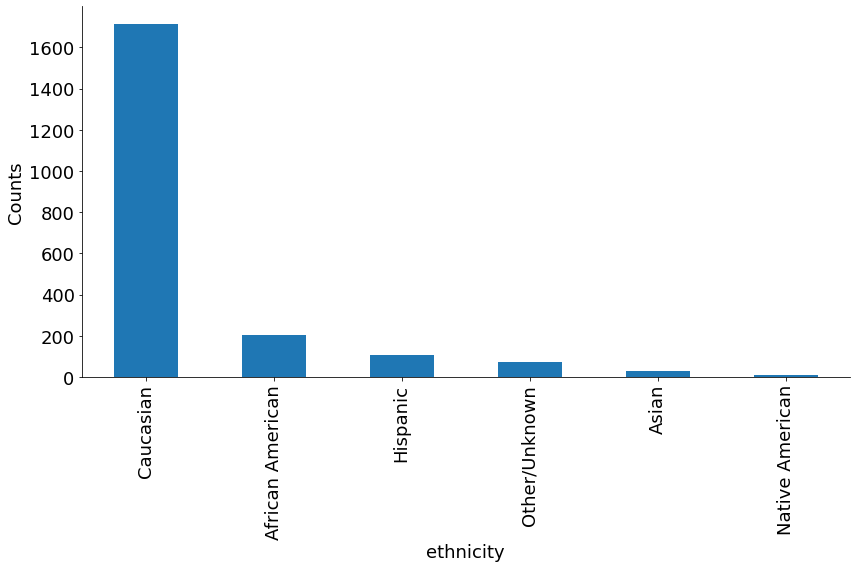

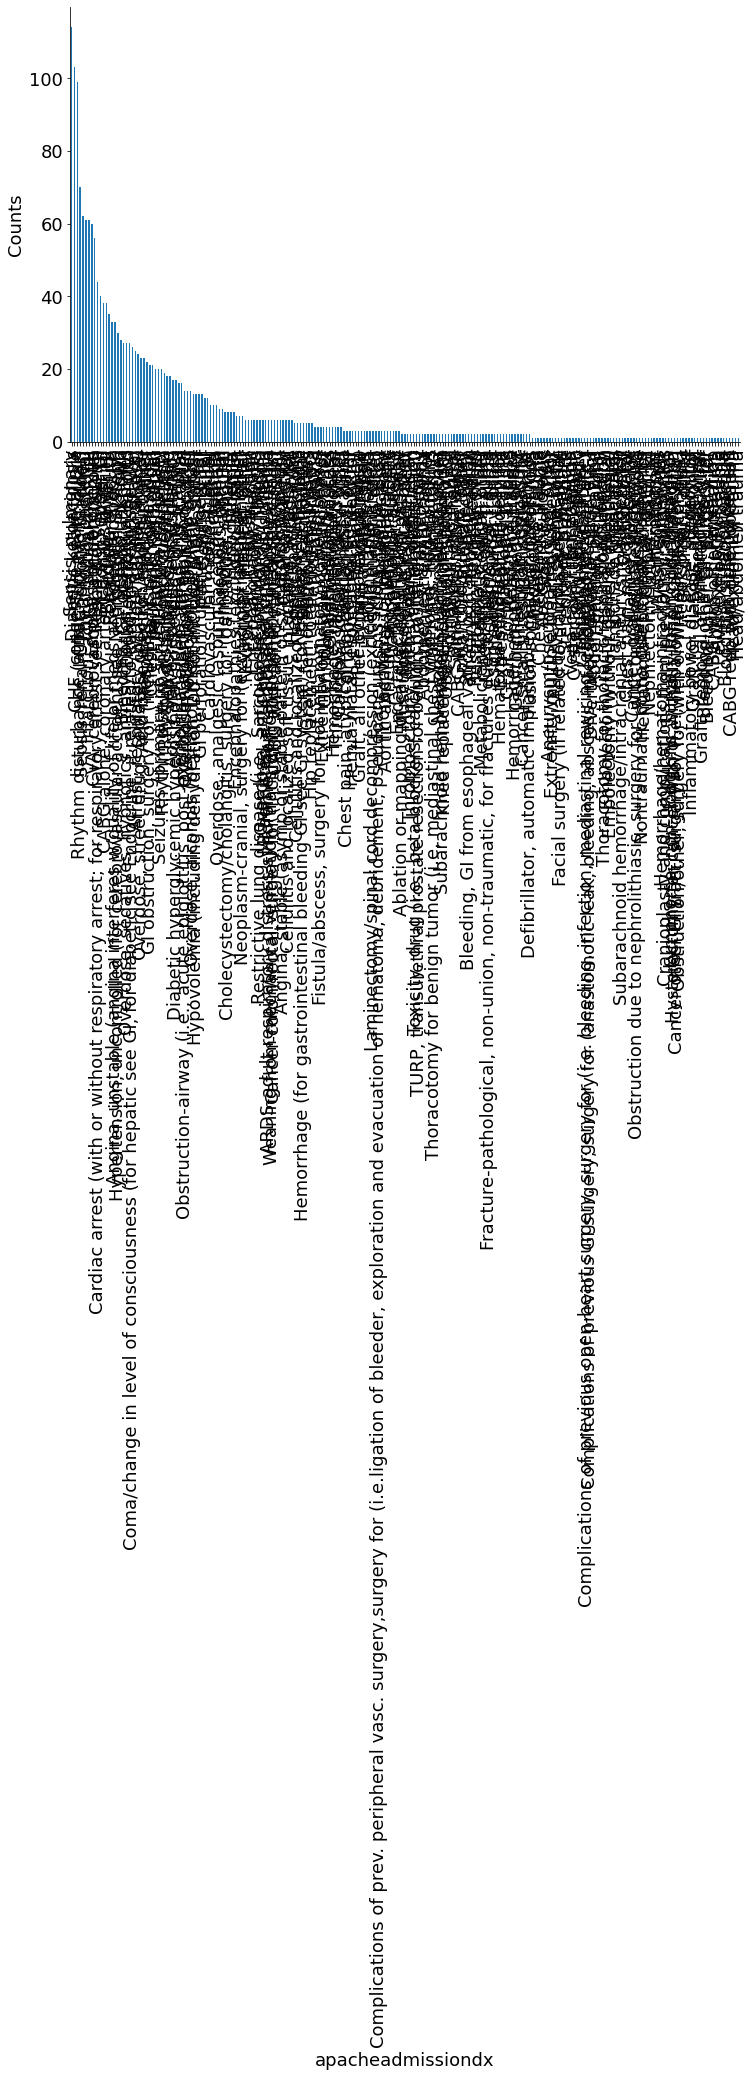

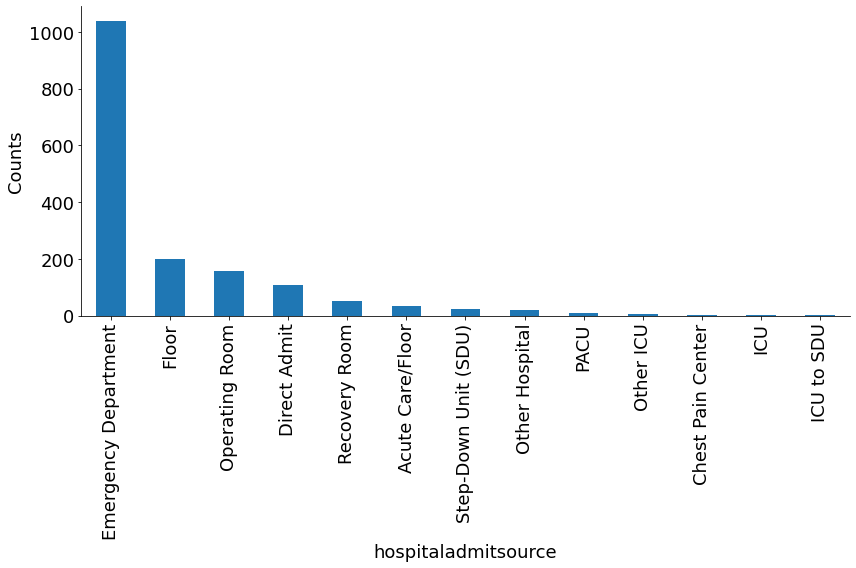

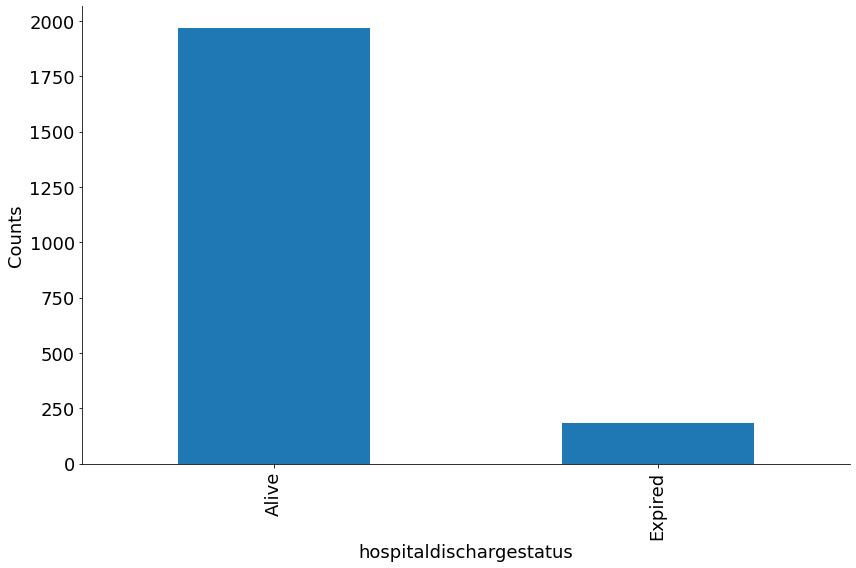

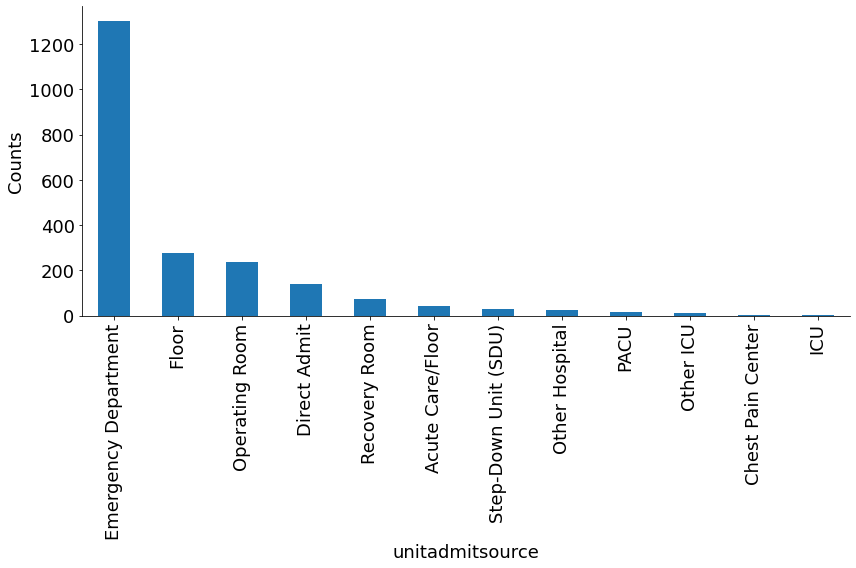

In [16]:
#fig, ax = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(18, 36))
for feat in categorical_features:
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    patients[feat].value_counts().plot(kind="bar", ax=ax, fontsize=18)
    ax.set_xlabel(f"{feat}", fontsize=18)
    ax.set_ylabel("Counts", fontsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()


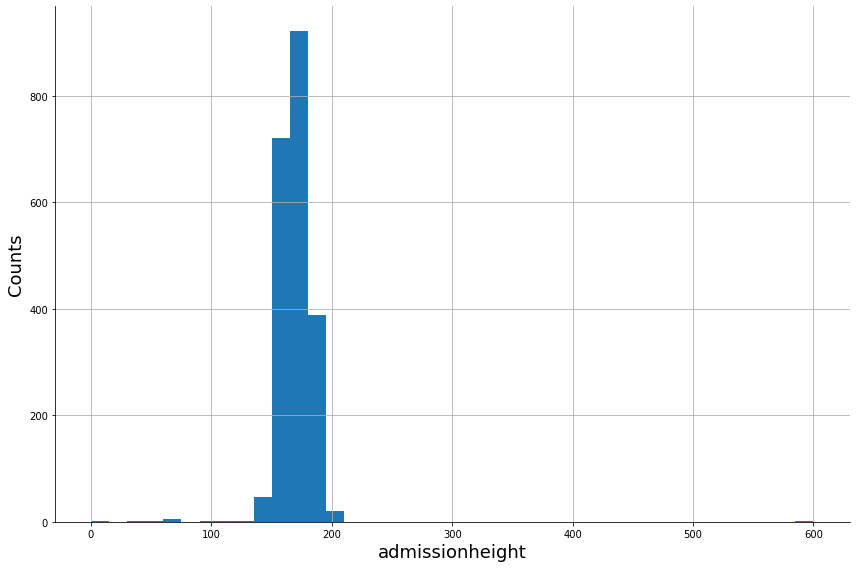

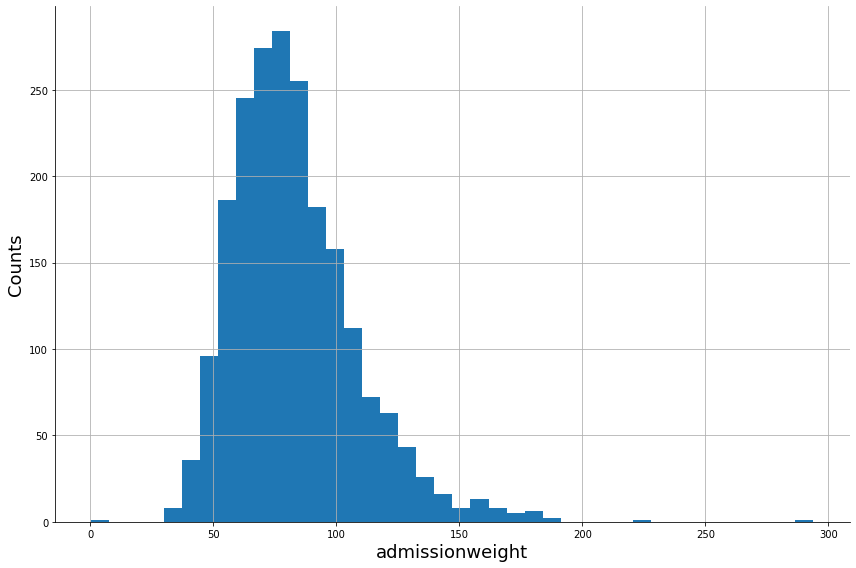

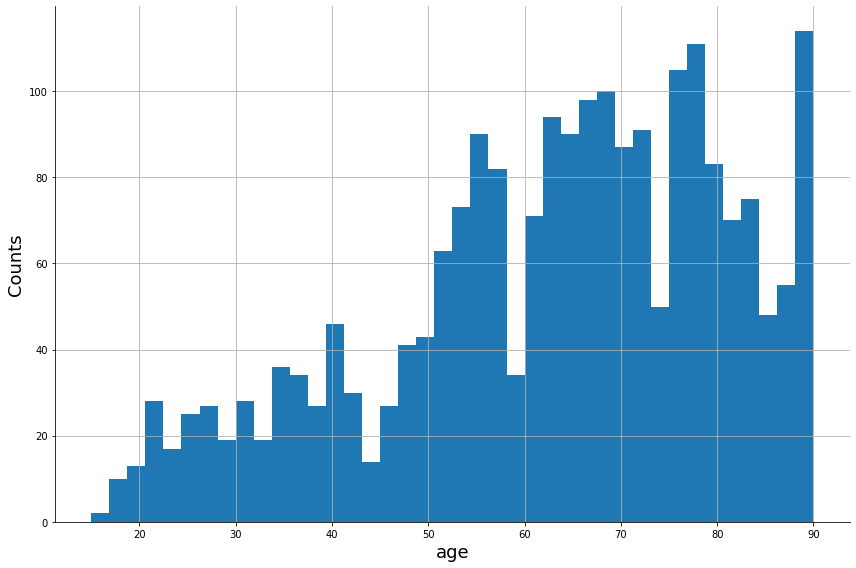

In [17]:
for feat in ["admissionheight", "admissionweight", "age"]:
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    patients[feat].hist(ax=ax, bins=40)
    ax.set_xlabel(f"{feat}", fontsize=18)
    ax.set_ylabel("Counts", fontsize=18)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()

Let us generate some features for our prediction task

In [18]:
patients["outcome"] = np.where(patients["hospitaldischargestatus"] == "Alive", 0, 1)
patients["admitsource"] = np.where(patients["hospitaladmitsource"] == "Emergency Department", 1, 0)
patients["gender"] = np.where(patients["gender"] == "Female", 1, 0)
patients = patients.drop(["hospitaldischargestatus", "hospitaladmitsource", "unitadmitsource", "apacheadmissiondx", "ethnicity"], axis=1)

In [19]:
patients.head()

,patienthealthsystemstayid,gender,age,admissionheight,admissionweight,outcome,admitsource
1,129391,1,87.0,157.5,46.5,0,0
2,131022,0,76.0,167.0,77.5,0,0
3,131736,1,34.0,172.7,60.3,0,1
4,132209,0,61.0,177.8,91.7,0,1
6,133684,1,55.0,157.5,72.5,0,0


In [20]:
patients.dtypes

patienthealthsystemstayid      int64
gender                         int64
age                          float64
admissionheight              float64
admissionweight              float64
outcome                        int64
admitsource                    int64
dtype: object

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
len(patients["patienthealthsystemstayid"].unique())

2174

# Task 2: Generate a train/test split with sizes 80% / 20%

In [23]:
train_pat_ids, test_pat_ids = train_test_split(patients["patienthealthsystemstayid"].unique(), test_size=0.2)

In [24]:
train_patients = patients[patients["patienthealthsystemstayid"].isin(train_pat_ids)]
test_patients = patients[patients["patienthealthsystemstayid"].isin(test_pat_ids)]

# It is very important to carefully set up your test problem. It is unlikely that the model will perform well on the test data set if the distribution of the outcome (mortality) is very different from the outcome on the training data.

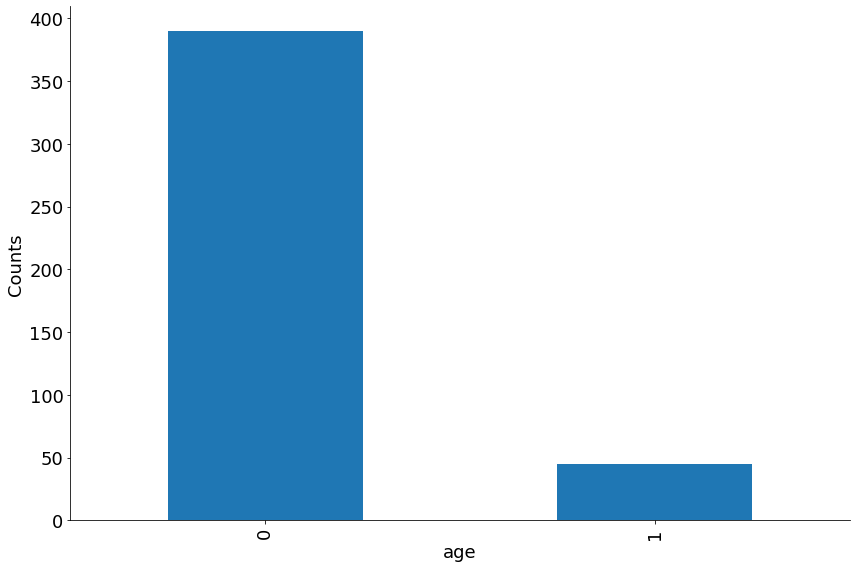

In [25]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
test_patients["outcome"].value_counts().plot(kind="bar", ax=ax, fontsize=18)
ax.set_xlabel(f"{feat}", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()

In [26]:
no_alive_test = len(test_patients[test_patients["outcome"] == 0])
no_died_test = len(test_patients[test_patients["outcome"] == 1])
no_total_test = no_alive_test + no_died_test

In [27]:
print(f"{no_alive_test} patients who left the hospital alive ({100*no_alive_test/no_total_test:.2f}%) and {no_died} who died in hospital ({100*no_died_test/no_total_test:.2f}%).")

390 patients who left the hospital alive (89.66%) and 212 who died in hospital (10.34%).


In [28]:
train_patients.head()

,patienthealthsystemstayid,gender,age,admissionheight,admissionweight,outcome,admitsource
1,129391,1,87.0,157.5,46.5,0,0
3,131736,1,34.0,172.7,60.3,0,1
4,132209,0,61.0,177.8,91.7,0,1
6,133684,1,55.0,157.5,72.5,0,0
7,134042,1,60.0,154.9,95.6,0,0


In [29]:
train_patients.dtypes

patienthealthsystemstayid      int64
gender                         int64
age                          float64
admissionheight              float64
admissionweight              float64
outcome                        int64
admitsource                    int64
dtype: object

In [30]:
x_train = train_patients[["gender", "age", "admissionheight", "admissionweight"]].to_numpy()
y_train = train_patients[["outcome"]].to_numpy()

# Which model should we use?

- How can we evaluate whether a complex model gives us a benefit?
- What is the simplest model you can think of?

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [32]:
model.fit(x_train, y_train)

ValueError: ignored

# Oops, we got ahead of ourselves... Not all rows and columns contain valid data

Missingness is a problem we encounter often when working with electronic health records

In [33]:
train_patients.loc[train_patients.isna().any(axis=1), :]

,patienthealthsystemstayid,gender,age,admissionheight,admissionweight,outcome,admitsource
14,137216,0,44.0,172.7,NaN,0,0
17,138861,0,63.0,172.7,NaN,0,1
25,142615,1,57.0,NaN,NaN,0,0
37,146194,1,38.0,162.6,NaN,0,1
62,153282,1,74.0,152.6,NaN,0,0
...,...,...,...,...,...,...,...
2378,2561819,0,81.0,NaN,NaN,1,1
2398,2565956,0,63.0,NaN,NaN,0,1
2402,2566978,0,59.0,NaN,NaN,0,1
2411,2568702,0,74.0,NaN,NaN,0,0


# Task 3: Identify all columns that have missing values

In [34]:
train_patients.isna().any(axis=0)

patienthealthsystemstayid    False
gender                       False
age                           True
admissionheight               True
admissionweight               True
outcome                      False
admitsource                  False
dtype: bool

The simplest solution is to do mean or median imputation

In [35]:
means = train_patients.mean()

In [36]:
train_patients = train_patients.fillna(means)

In [37]:
train_patients.isna().any(axis=0)

patienthealthsystemstayid    False
gender                       False
age                          False
admissionheight              False
admissionweight              False
outcome                      False
admitsource                  False
dtype: bool

In [38]:
x_train = train_patients[["gender", "age", "admissionheight", "admissionweight"]].to_numpy()
y_train = np.squeeze(train_patients[["outcome"]].to_numpy())

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [40]:
model = LogisticRegression()

In [41]:
model.fit(x_train, y_train)

LogisticRegression()

In [42]:
y_hat = model.predict(x_train)

In [43]:
score = accuracy_score(y_train, y_hat)

In [44]:
print(score)

0.9068430132259919


# We have an accuracy above 90% !
Let's look at predictions...

Text(0.5, 0, 'Predictions')

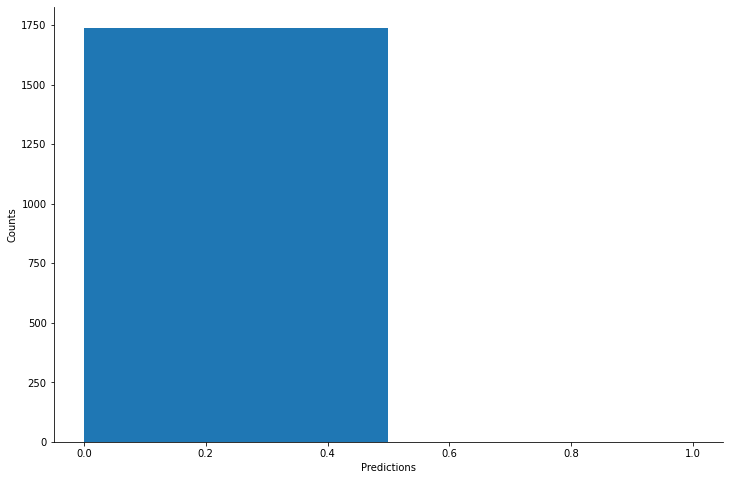

In [45]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(y_hat, bins=[0, 0.5, 1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Counts")
ax.set_xlabel("Predictions")

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

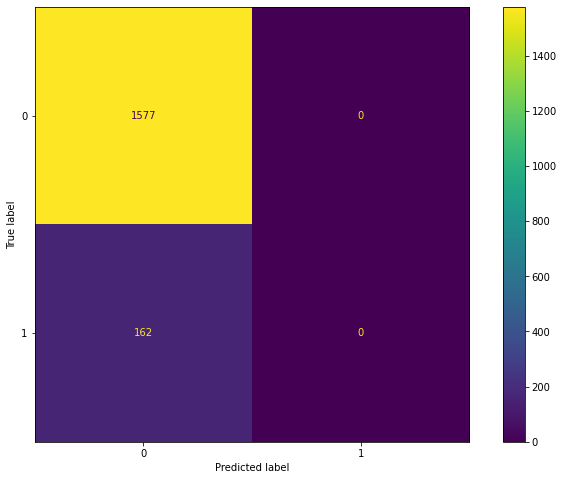

In [47]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(y_train, y_hat)
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax=ax)

In [48]:
from sklearn.metrics import average_precision_score

In [49]:
average_precision_score(y_train, y_hat)

0.09315698677400805

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [52]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [53]:
models = {
    "SVM": SVC(),
    "KNN5": KNeighborsClassifier(n_neighbors=5),
    "KNN10": KNeighborsClassifier(n_neighbors=10),
    "KNN15": KNeighborsClassifier(n_neighbors=15),
    "KNN20": KNeighborsClassifier(n_neighbors=20),
    "GBC": GradientBoostingClassifier(),
    "mlp_0": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    "mlp_1": MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000),
    "mlp_2": MLPClassifier(hidden_layer_sizes=(100, 50, 30), max_iter=1000)
}

In [54]:
for model_name, model in models.items():
    results = cross_validate(model, scaler.transform(x_train), y_train, cv=5, scoring="average_precision")
    print(model_name, results["test_score"], np.median(results["test_score"]))

SVM [0.09384042 0.09687632 0.10371931 0.07781676 0.09943294] 0.09687632203780375
KNN5 [0.08894055 0.08740593 0.12275713 0.09854084 0.11114866] 0.09854083500320511
KNN10 [0.09424515 0.08751379 0.13853195 0.10170722 0.12846358] 0.10170721665539754
KNN15 [0.08820557 0.09174434 0.1673969  0.10756676 0.15419115] 0.10756676410720761
KNN20 [0.09495686 0.09082828 0.15368563 0.11655971 0.15378228] 0.11655971126142796
GBC [0.16149356 0.10799978 0.14724361 0.10299222 0.18245785] 0.14724361288419244
mlp_0 [0.13963613 0.10547169 0.15346626 0.11346187 0.19071084] 0.13963613193214908
mlp_1 [0.10024749 0.09513313 0.11760644 0.11653046 0.13044439] 0.11653045622097742
mlp_2 [0.09110497 0.08950931 0.118827   0.11223933 0.13477099] 0.11223933274433454


In [55]:
models["GBC"].fit(scaler.transform(x_train), y_train)

GradientBoostingClassifier()

In [56]:
y_hat = models["GBC"].predict(scaler.transform(x_train))

In [57]:
y_hat

array([0, 0, 0, ..., 0, 0, 0])

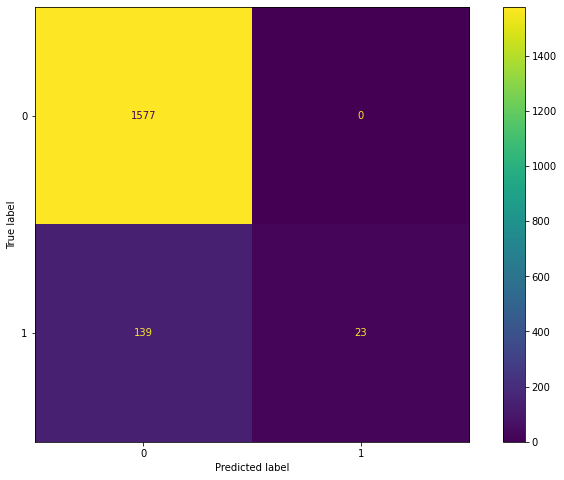

In [58]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(y_train, y_hat)
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax=ax)

# How can we make better predictions?
We do have more data available...

# Task 4: Predictions on the test set

In [61]:
x_test = test_patients[["gender", "age", "admissionheight", "admissionweight"]].fillna(means).to_numpy()
y_test = np.squeeze(test_patients[["outcome"]].to_numpy())

In [62]:
y_hat = models["GBC"].predict(scaler.transform(x_test))

In [64]:
from sklearn.metrics import average_precision_score

In [65]:
average_precision_score(y_test, y_hat)

0.10855683269476372

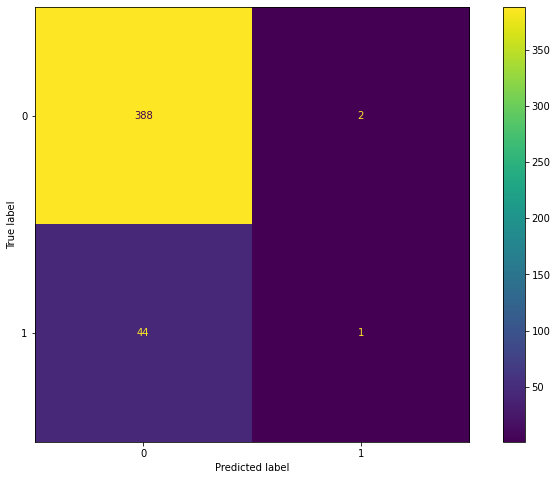

In [63]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax=ax)

# Solution to tasks:



In [ ]:
# Task 1:

# patients = patients.loc[patients.groupby("patienthealthsystemstayid")["unitvisitnumber"].idxmin().reset_index(drop=True), :]

In [ ]:
# Task 2:

# train_pat_ids, test_pat_ids = train_test_split(patients["patienthealthsystemstayid"].unique(), test_size=0.2)

In [ ]:
# Task 3:

# train_patients.isna().any(axis=0)